# wedge modeling

I wanted to do seismic forward modeling in Python for the purpose of investigating AVO effects, so not just zero-offset stack wedges but partial angle stacks too.

What I did is more or less copy Matt Hall and Evan Bianco's work illustrated in several blog posts and notebook, made some modifications especially to the way wedges are built, introduced a way to calculate non-zero offset reflections using AVO equations and put it all together in simple functions that have made my life much easier. The most recent addition I made here is a function to do simple auotracking of top/bottom horizons (see at the end of this notebook).

To run the code we need Numpy, matplotlib, and [Agilegeo](http://www.agilegeoscience.com/)'s [geophysics library](http://code.agilegeoscience.com/agilegeo/). If you don't have it, install it with:

    $ pip install agilegeo

This notebook is structured into two main parts: first I will define all the **functions** then I will show how to use all of  these functions with some **examples**.

To use all these functions outside of an IPython notebook environment, simply download [`aawedge.py`](https://github.com/aadm/geophysical_notes/blob/master/aawedge.py), copy it to your working directory and import all the function in your Python environment like this:

    >>> from aawedge import *
    
*NOTE: please note that I haven't yet updated this notebook with the new library from Agile Geoscience, [bruges](http://www.agilegeoscience.com/bruges/).*

## functions

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import agilegeo
%matplotlib inline
# comment out the following if you're not on a Mac with HiDPI display
%config InlineBackend.figure_format = 'retina'

Let's define the basic function to build a generic wedge made of 3 different rock-types: it only asks for number of traces, thickness of the first layer, then minimum and maximum wedge thicknesses so that you can build anything from a slab of rock to a proper wedge that thins out to zero. The number of samples will be calculated internally on the basis of the vertical resolution in meter that is set with parameter `dz`; I usually have this set to 0.1 meters.

In [20]:
def make_wedge(n_traces,encasing_thickness,min_thickness,max_thickness,dz=0.1):
    '''
    Creates wedge-shaped model made of 3 units with variable thickness.

    INPUT
    n_traces
    encasing_thickness
    min_thickness
    max_thickness
    dz: vertical sample rate, by default 0.1 m

    OUTPUT
    wedge: 2D numpy array containing wedge-shaped model made of 3 units
    '''
    encasing_thickness *= (1./dz)
    min_thickness *= (1./dz)
    max_thickness *= (1./dz)
    deltaz=float(max_thickness-min_thickness)/float(n_traces)
    n_samples=max_thickness+encasing_thickness*2
    top_wedge=encasing_thickness
    wedge = np.zeros((n_samples, n_traces))
    wedge[0:encasing_thickness,:]=1
    wedge[encasing_thickness:,:]=3
    wedge[encasing_thickness:encasing_thickness+min_thickness,:]=2
    for i in range(n_traces):
        wedge[encasing_thickness+min_thickness:encasing_thickness+min_thickness+int(round(deltaz*i)),i]=2
    print "wedge minimum thickness: %.2f m" % (min_thickness*dz)
    print "wedge maximum thickness: %.2f m" % (max_thickness*dz)
    print "wedge vertical sampling: %.2f m" % (dz)
    print "wedge samples, traces: %dx%d" % (wedge.shape)
    return wedge

These are the functions to create acoustic impedance (`assign_ai`), elastic properties (`assign_el`) and velocity models (`assign_vel`) starting from the 3-rock types that our wedge is made of. The velocity model is used to convert the resulting model from depth to two-way-time.

In [21]:
def assign_ai(model, aiprop):
    '''
    Assigns acoustic impedance to a rock model created with make_wedge.

    INPUT
    model: 2D numpy array containing values from 1 to 3
    aiprop: np.array(([vp1,rho1],[vp2,rho2],[vp3,rho3]))

    OUTPUT
    model_ai: 2D numpy array containing acoustic impedances
    '''
    model_ai=np.zeros(model.shape)
    code = 1
    for x in aiprop:
        model_ai[model==code] = x[0]*x[1]
        code += 1
    return model_ai

def assign_el(model, elprop):
    '''
    Assigns elastic properties (Vp, Vs, rho) to a rock model created with make_wedge.

    INPUT
    model: 2D numpy array containing values from 1 to 3
    elprop: np.array(([vp1,rho1,vs1],[vp2,rho2,vs2],[vp3,rho3,vs3]))

    OUTPUT
    model_vp: 2D numpy array containing Vp
    model_vs: 2D numpy array containing Vs
    model_rho: 2D numpy array containing densities
    '''
    model_vp=np.zeros(model.shape)
    model_vs=np.zeros(model.shape)
    model_rho=np.zeros(model.shape)
    code = 1
    for i in elprop:
        model_vp[model==code]  = i[0]
        model_vs[model==code]  = i[2]
        model_rho[model==code] = i[1]
        code += 1
    return model_vp,model_vs,model_rho

def assign_vel(model, aiprop):
    '''
    Assigns velocity to a rock model created with make_wedge,
    to be used for depth-time conversion.

    INPUT
    model: 2D numpy array containing values from 1 to 3
    aiprop: np.array(([vp1,rho1],[vp2,rho2],[vp3,rho3]))

    OUTPUT
    model_vel: 2D numpy array containing velocities
    '''
    model_vel=np.zeros(model.shape)
    code=1
    for x in aiprop:
        model_vel[model==code] = x[0]
        code += 1
    return model_vel

The following functions are used to create reflection coefficients for both the zero-offset / acoustic model (`make_rc`) and the variable-offsets / elastic models (`make_rc_elastic`):

In [22]:
def make_rc(model_ai):
    '''
    Computes reflectivities of an acoustic model
    created with make_wedge + assign_ai.

    INPUT
    model: 2D numpy array containing acoustic impedances

    OUTPUT
    rc: 2D numpy array containing reflectivities
    '''
    upper = model_ai[:-1][:][:]
    lower = model_ai[1:][:][:]
    rc=(lower - upper) / (lower + upper)
    if model_ai.ndim==1:
        rc=np.concatenate((rc,[0]))
    else:
        n_traces=model_ai.shape[1]
        rc=np.concatenate((rc,np.zeros((1,n_traces))))  # add 1 row of zeros at the end
    return rc

def make_rc_elastic(model_vp,model_vs,model_rho,ang):
    '''
    Computes angle-dependent reflectivities of an elastic model
    created with make_wedge + assign_el.
    Uses Aki-Richards approximation.

    INPUT
    model_vp: 2D numpy array containing Vp values
    model_vs: 2D numpy array containing Vs values
    model_rho: 2D numpy array containing density values
    ang: list with near, mid, far angle, e.g. ang=[5,20,40]

    OUTPUT
    rc_near: 2D numpy array containing near-stack reflectivities
    rc_mid: 2D numpy array containing mid-stack reflectivities
    rc_far: 2D numpy array containing far-stack reflectivities
    '''
    from agilegeo.avo import akirichards
    [n_samples, n_traces] = model_vp.shape
    rc_near=np.zeros((n_samples,n_traces))
    rc_mid=np.zeros((n_samples,n_traces))
    rc_far=np.zeros((n_samples,n_traces))
    uvp  = model_vp[:-1][:][:]
    lvp  = model_vp[1:][:][:]
    uvs  = model_vs[:-1][:][:]
    lvs  = model_vs[1:][:][:]
    urho = model_rho[:-1][:][:]
    lrho = model_rho[1:][:][:]
    rc_near=akirichards(uvp,uvs,urho,lvp,lvs,lrho,ang[0])
    rc_mid=akirichards(uvp,uvs,urho,lvp,lvs,lrho,ang[1])
    rc_far=akirichards(uvp,uvs,urho,lvp,lvs,lrho,ang[2])
    rc_near=np.concatenate((rc_near,np.zeros((1,n_traces))))  # add 1 row of zeros at the end
    rc_mid=np.concatenate((rc_mid,np.zeros((1,n_traces))))
    rc_far=np.concatenate((rc_far,np.zeros((1,n_traces))))
    return rc_near, rc_mid, rc_far

And to to create seismic data from the reflection coefficients:

In [23]:
def make_synth(rc,wavelet):
    '''
    Convolves reflectivities with wavelet.

    INPUT
    rc: 2D numpy array containing reflectivities
    wavelet

    OUTPUT
    synth: 2D numpy array containing seismic data
    '''
    nt=np.size(wavelet)
    [n_samples, n_traces] = rc.shape
    synth = np.zeros((n_samples+nt-1, n_traces))
    for i in range(n_traces):
        synth[:,i] = np.convolve(rc[:,i], wavelet)
    synth = synth[np.ceil(len(wavelet))/2:-np.ceil(len(wavelet))/2, :]
    synth=np.concatenate((synth,np.zeros((1,n_traces))))
    return synth

These are helper functions to put all the above steps together:

In [24]:
def forward_model(model,aiprop,wavelet,dz,dt):
    """
    Meta function to do everything from scratch (zero-offset model).
    """
    earth = assign_ai(model, aiprop)
    vels = assign_vel(model, aiprop)
    earth_time=agilegeo.avo.depth_to_time(earth,vels,dz,dt,twt=True)
    rc = make_rc(earth_time)
    return make_synth(rc,wavelet)

def forward_model_elastic(model,elprop,wavelet,ang,dz,dt):
    """
    Meta function to do everything from scratch (angle-dependent models).
    """
    model_vp,model_vs,model_rho = assign_el(model,elprop)
    model_vp_time=agilegeo.avo.depth_to_time(model_vp,model_vp,dz,dt,twt=True)
    model_vs_time=agilegeo.avo.depth_to_time(model_vs,model_vp,dz,dt,twt=True)
    model_rho_time=agilegeo.avo.depth_to_time(model_rho,model_vp,dz,dt,twt=True)

    rc_near, rc_mid, rc_far=make_rc_elastic(model_vp_time,model_vs_time,model_rho_time,ang)
    near = make_synth(rc_near,wavelet)
    mid = make_synth(rc_mid,wavelet)
    far = make_synth(rc_far,wavelet)
    return near,mid,far

def forward_model_elastic_decay(model,elprop,wav_near,wav_mid,wav_far,dz,dt):
    """
    Meta function to do everything from scratch (angle-dependent models).
    Uses angle-dependent wavelet to simulate frequency decay with offset.
    """
    model_vp,model_vs,model_rho = assign_el(model,elprop)
    model_vp_time=agilegeo.avo.depth_to_time(model_vp,model_vp,dz,dt,twt=True)
    model_vs_time=agilegeo.avo.depth_to_time(model_vs,model_vp,dz,dt,twt=True)
    model_rho_time=agilegeo.avo.depth_to_time(model_rho,model_vp,dz,dt,twt=True)

    rc_near, rc_mid, rc_far=make_rc_elastic(model_vp_time,model_vs_time,model_rho_time,ang)
    near = make_synth(rc_near,wav_near)
    mid = make_synth(rc_mid,wav_mid)
    far = make_synth(rc_far,wav_far)
    return near,mid,far

I also want to define some plotting functions to make the whole business of checking things out *much* faster:

In [25]:
def plot_wavelet(wavelet,time):
    '''
    Plots wavelet.
    Required timescale can be calculated with:

    time=np.arange(-duration/2, duration/2 , dt)

    where duration and dt (sample rate) are also given input to calculate wavelet.
    '''
    plt.figure(figsize=(8,5))
    plt.plot(time,wavelet,lw=2,color='black')
    plt.fill_between(time,wavelet,0,wavelet>0.0,interpolate=False,hold=True,color='blue', alpha = 0.5)
    plt.fill_between(time,wavelet,0,wavelet<0.0,interpolate=False,hold=True,color='red', alpha = 0.5)
    plt.grid()
    plt.xlim(-0.1,0.1)
    locs,labels = plt.xticks()
    plt.xticks(locs[:-1], map(lambda x: "%d" % x, locs[:-1]*1000))
    plt.xlabel( 'two-way time (ms)')

def plot_rock_grid(data,zz=1):
    '''
    Plots rock model created with make_wedge.

    INPUT
    data: 2D numpy array containing values from 1 to 3
    zz: vertical sample rate in depth
    '''
    import matplotlib.cm as cm
    cc=cm.get_cmap('copper_r',3)
    plt.figure(figsize=(12,6))
    plt.imshow(data,extent=[0,data.shape[1],data.shape[0]*zz,0],cmap=cc,interpolation='none',aspect='auto')
    cbar=plt.colorbar()
    cbar.set_ticks(range(1,4)); cbar.set_ticklabels(range(1,4))
    plt.grid()

def plot_density(data,zz=1,seismic=True):
    '''
    Density plot of generic 2D numpy array (seismic or any property e.g., velocity).

    INPUT
    data: 2D numpy array containing seismic or elastic property
    zz: vertical sample rate in depth or time
    seismic: True to use red-blue colorscale
    '''
    plt.figure(figsize=(12,6))
    if seismic==True:
        clip=np.amax(abs(data))
        plt.imshow(data,extent=[0,data.shape[1],data.shape[0]*zz,0],cmap='RdBu',vmax=clip,vmin=-clip,aspect='auto')
    else:
        plt.imshow(data,extent=[0,data.shape[1],data.shape[0]*zz,0],cmap='PiYG',aspect='auto')
    plt.colorbar(), plt.grid()

def plot_wiggle(data,zz=1,skip=1,gain=1,alpha=0.5,black=False):
    '''
    Wiggle plot of generic 2D numpy array.

    INPUT
    data: 2D numpy array
    zz: vertical sample rate in depth or time
    skip: interval to choose traces to draw
    gain: multiplier applied to each trace
    '''
    [n_samples,n_traces]=data.shape
    t=range(n_samples)
    plt.figure(figsize=(9.6,6))
    for i in range(0, n_traces,skip):
        trace=gain*data[:,i] / np.max(np.abs(data))
        plt.plot(i+trace,t,color='k', linewidth=0.5)
        if black==False:
            plt.fill_betweenx(t,trace+i,i, where=trace+i>i, facecolor=[0.6,0.6,1.0], linewidth=0)
            plt.fill_betweenx(t,trace+i,i, where=trace+i<i, facecolor=[1.0,0.7,0.7], linewidth=0)
        else:
            plt.fill_betweenx(t,trace+i,i, where=trace+i>i, facecolor='black', linewidth=0, alpha=alpha)
    locs,labels=plt.yticks()
    plt.yticks(locs,[n*zz for n in locs.tolist()])
    plt.grid()
    plt.gca().invert_yaxis()

def plot_partial_stacks(near,mid,far,zz=1,label=''):
    '''
    Density plot of near, mid, far stacks.

    INPUT
    near, mid, far: 2D numpy arrays containing seismic
    zz: vertical sample rate in twt
    label
    '''
    clip=np.amax([abs(near), abs(mid), abs(far)])
    f, ax = plt.subplots(nrows=1, ncols=3, figsize=(10,4))
    im0=ax[0].imshow(near,extent=[0,near.shape[1],near.shape[0]*zz,0],cmap='RdBu',vmax=clip,vmin=-clip,aspect='auto')
    ax[0].set_title(label+' (NEAR)',fontsize='small')
    im1=ax[1].imshow(mid,extent=[0,near.shape[1],near.shape[0]*zz,0],cmap='RdBu',vmax=clip,vmin=-clip,aspect='auto')
    ax[1].set_title(label+' (MID)',fontsize='small')
    im2=ax[2].imshow(far,extent=[0,near.shape[1],near.shape[0]*zz,0],cmap='RdBu',vmax=clip,vmin=-clip,aspect='auto')
    ax[2].set_title(label+' (FAR)',fontsize='small')
    ax[0].set_ylabel('twt [s]')
    cax = f.add_axes([0.925, 0.25, 0.02, 0.5])
    cbar=f.colorbar(im0, cax=cax, orientation='vertical')
    for i in range(len(ax)):
        ax[i].grid()

def update_xlabels(min_thickness,max_thickness,n_traces):
    '''
    Updates x_labels with actual thickness of model (in meters).
    '''
    locs,labels=plt.xticks()
    incr=(max_thickness-min_thickness)/(float(n_traces))
    newlabels=(locs[1:-1])*incr+min_thickness
    plt.xticks(locs[1:-1],[str(round(x,1))+'m' for x in newlabels])

def update_ylabels(lag,thickness,vel):
    '''
    Updates y_labels to add lag in two-way-time,
    given velocity of top layer having certain thickness.
    '''
    locs,labels=plt.yticks()
    lagtop=thickness/vel*2
    plt.yticks(locs[:-1],[round(y+lag-lagtop,3) for y in locs])

## examples

The inputs required are:

* elastic properties for the 3 rock-types
* minimum and maximum thickness of the wedge
* the thickness of the top layer (i.e., rock-type 1)
* the number of traces
* a wavelet
* depth and time sample rates
* 3 angles for the variable-offset stacks / elastic models

I will use the class III gas sand elastic properties taken from Hilterman's [Seismic Amplitude Interpretation](http://library.seg.org/doi/book/10.1190/1.9781560801993) (secion 4.13):


class III AVO | Vp   | Vs    | density
--------------|------|-------|----------
shale         | 2192 | 818   | 2.16
gas sand      | 1543 | 901   | 1.88
brine sand    | 2134 | 860   | 2.11

#### plain wedge

Let's first build a gas sand wedge encased in shale. The workflow allow the user to specify different properties for the layer 2 (above the sand wedge) and 3 (below the sand wedge); for this case we will have the same shale in both layers 2 and 3. We need a Numpy array made of 3 rows, one for each rock-type, and each row consists of Vp, density and Vs (in this order):

    elastic_properties = np.array( [[ vp1, rho1, vs1],
                                    [ vp2, rho2, vs2],
                                    [ vp3, rho3, vs3]] )
    
For the zero-offset / acoustic model the Vs can be set to anything, it won't be used anyway.

In [26]:
acprop=np.array([[2191,2.16,0],[1543,1.88,0],[2191,2.16,0]])

These are the other inputs -- I use a vertical sample rate of 10 cm in depth (`srz=0.1`) and even finer in time (`srt=0.0001`) than the standard 1 or 4 ms (which would be `srt=0.001` or `srt=0.004`) just to have some smooth-looking wedge.

In [27]:
n_traces = 120
min_thickness = 5
max_thickness = 50
layer_1_thickness = 50
srz=0.1
srt=0.0001

Now I will define a wavelet and build its time scale (which is only used for the plotting function):

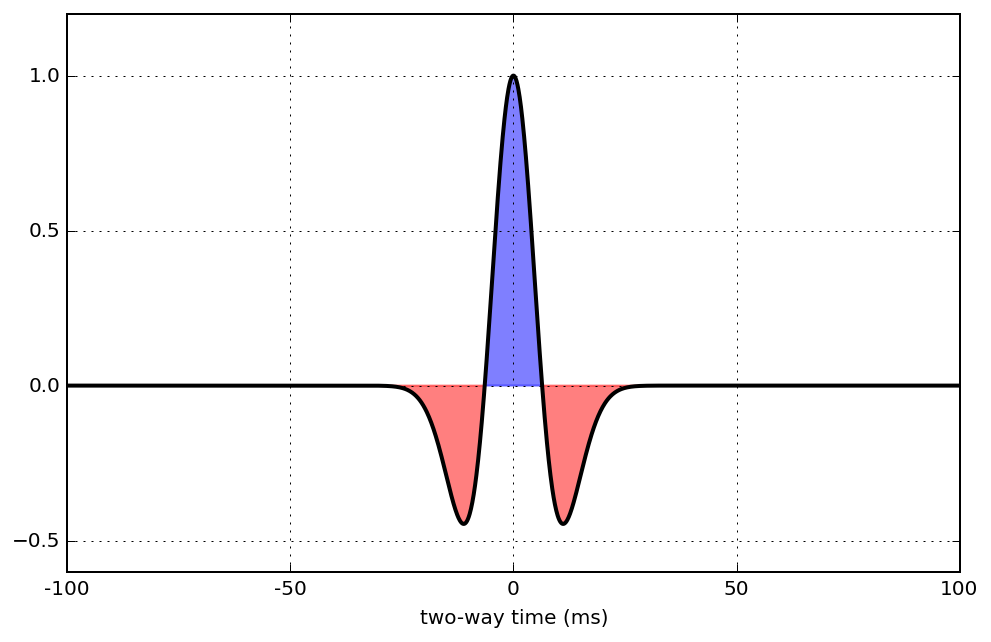

In [28]:
duration=.25
freq=35
wavl=agilegeo.wavelet.ricker(duration, srt, freq)
time=np.arange(-duration/2, duration/2 , srt)
plot_wavelet(wavl,time)

Let's build a wedge now and display it. I use the `plot_rock_grid` function which is valid only for these 3-rock units models I create with `make_wedge`, while `update_xlabels` is used to write as labels on the horizontal axis the actual thickness of the wedge:

wedge minimum thickness: 5.00 m
wedge maximum thickness: 50.00 m
wedge vertical sampling: 0.10 m
wedge samples, traces: 1500x120


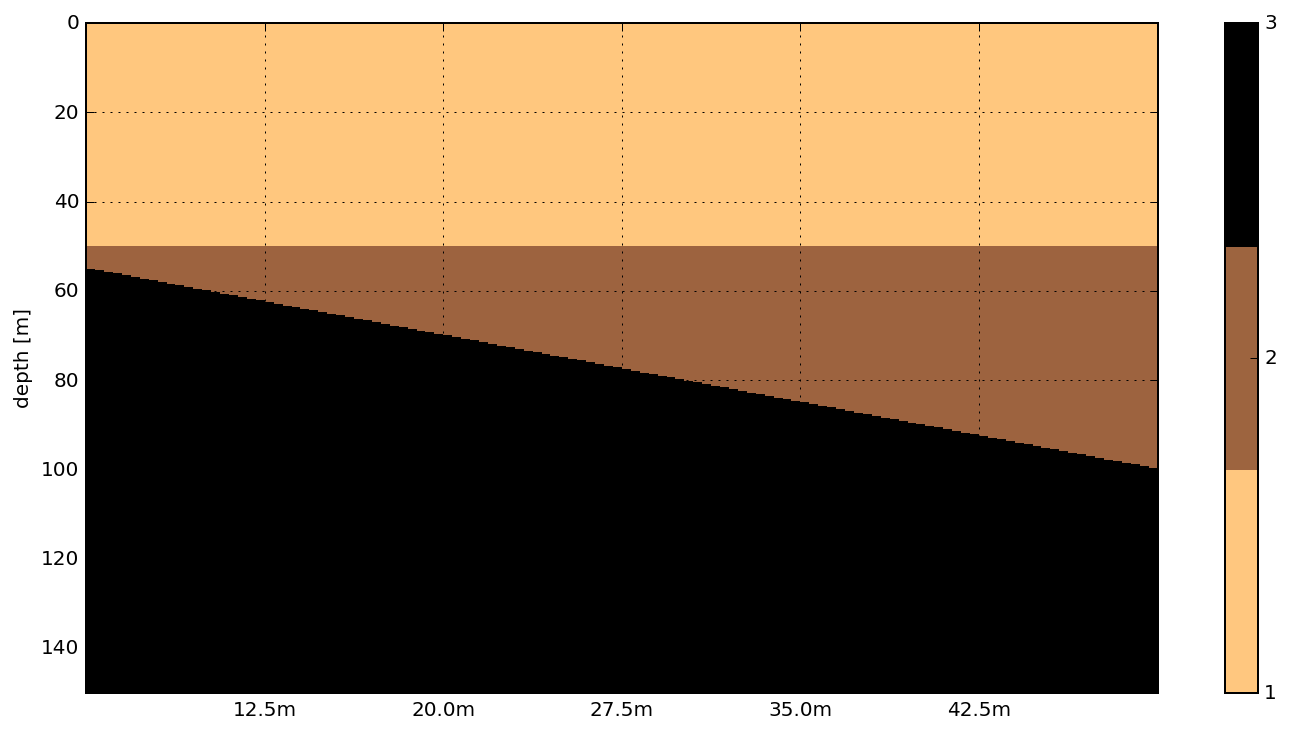

In [29]:
rock_grid=make_wedge(n_traces,layer_1_thickness,min_thickness,max_thickness,srz)
plot_rock_grid(rock_grid,srz), plt.ylabel('depth [m]')
update_xlabels(min_thickness,max_thickness,n_traces)

For the depth-to-time conversion I need a velocity model; I can build one using `assign_vel` and using as input the same `acprop` array defined at the beginning. Then I can use the `depth_to_time` function in `agilegeo.avo`, and display the two-way-time wedge using the same plotting functions as before:

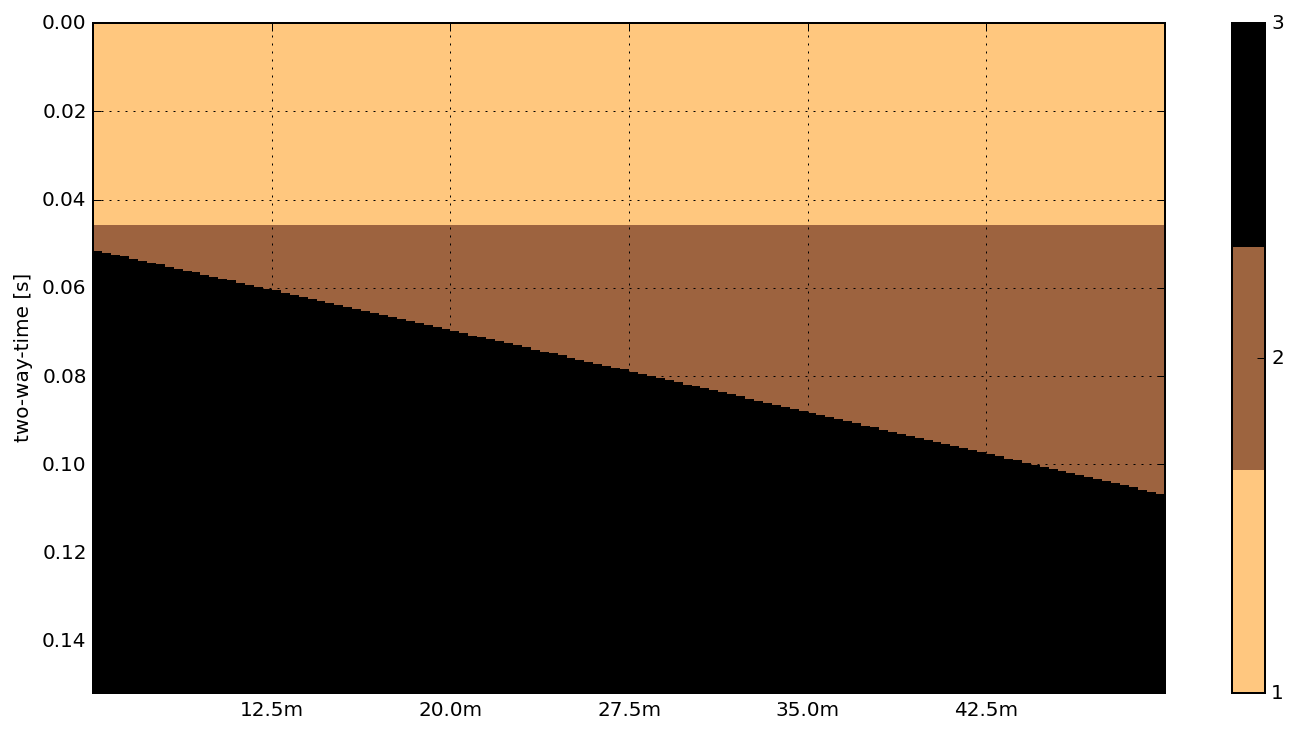

In [30]:
vels = assign_vel(rock_grid, acprop)
rock_grid_twt=agilegeo.avo.depth_to_time(rock_grid,vels,srz,srt,twt=True)
plot_rock_grid(rock_grid_twt,srt), plt.ylabel('two-way-time [s]')
update_xlabels(min_thickness,max_thickness,n_traces)

Now I use the `assign_ai` function to assign acoustic impedances to each rock-type contained in `rock_grid_twt`, compute zero-offset reflection coefficients (RC) with `make_rc` and generate seismic data by convolving this RC series with the previously defined wavelet (`make_synth`):

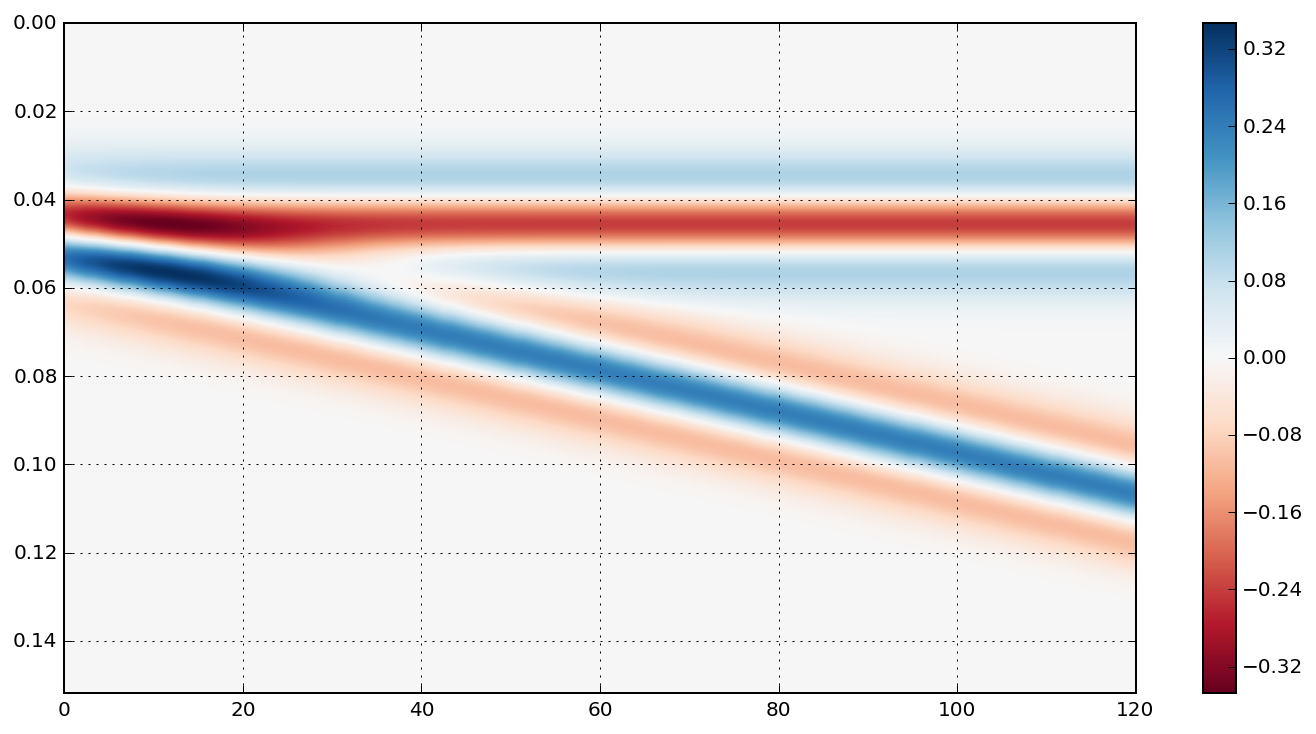

In [31]:
model=assign_ai(rock_grid_twt,acprop)
rc = make_rc(model)
seismic=make_synth(rc,wavl)
plot_density(seismic,srt)

For those who prefer wiggles, here's a plotting function you might like (note how the parameter `black` can be used to display the wiggles in the standard black-filled peaks style):

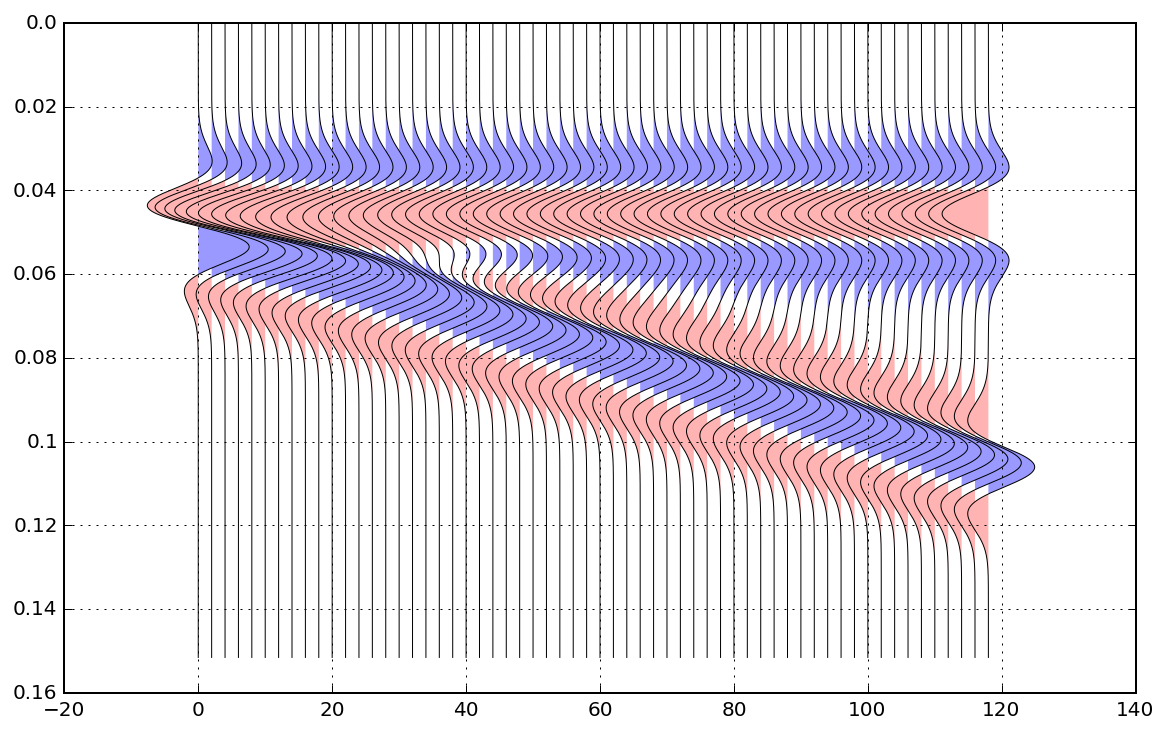

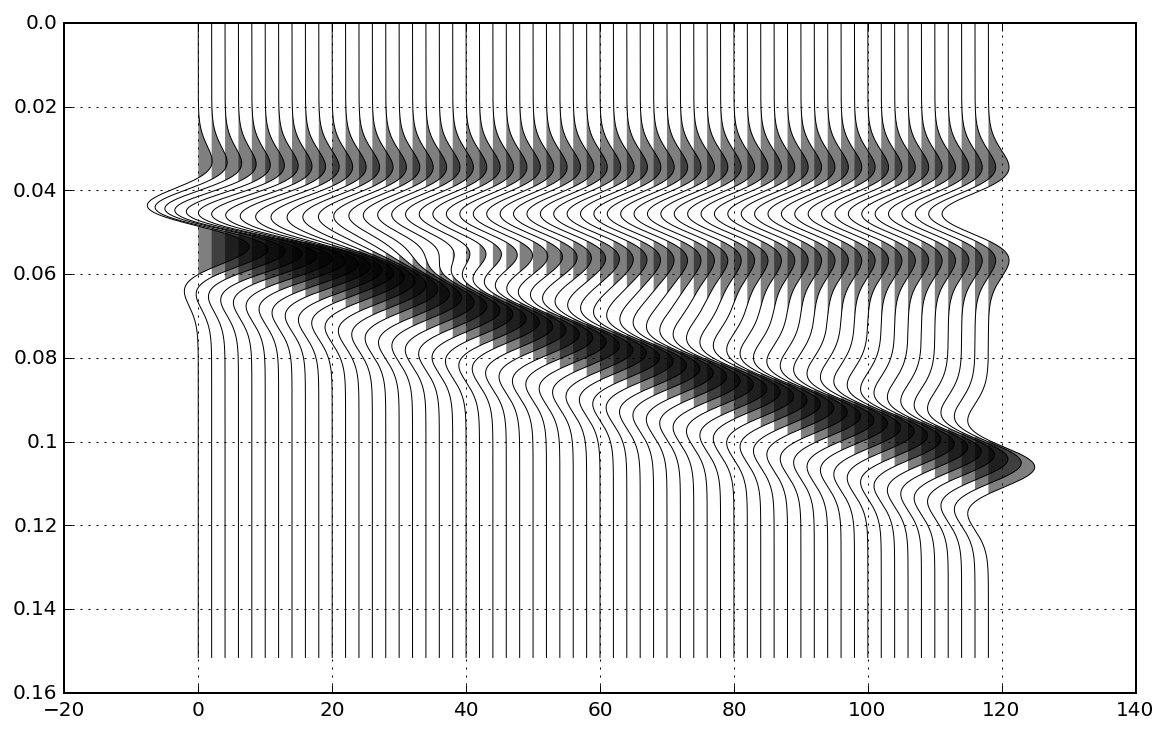

In [32]:
plot_wiggle(seismic,srt,skip=2,gain=10)
plot_wiggle(seismic,srt,skip=2,gain=10,black=True)

Here's how to make everything faster using the `forward_model` function -- let's build something like thicker sand with not a  lot of thickness variation:

wedge minimum thickness: 40.00 m
wedge maximum thickness: 50.00 m
wedge vertical sampling: 0.10 m
wedge samples, traces: 1500x120


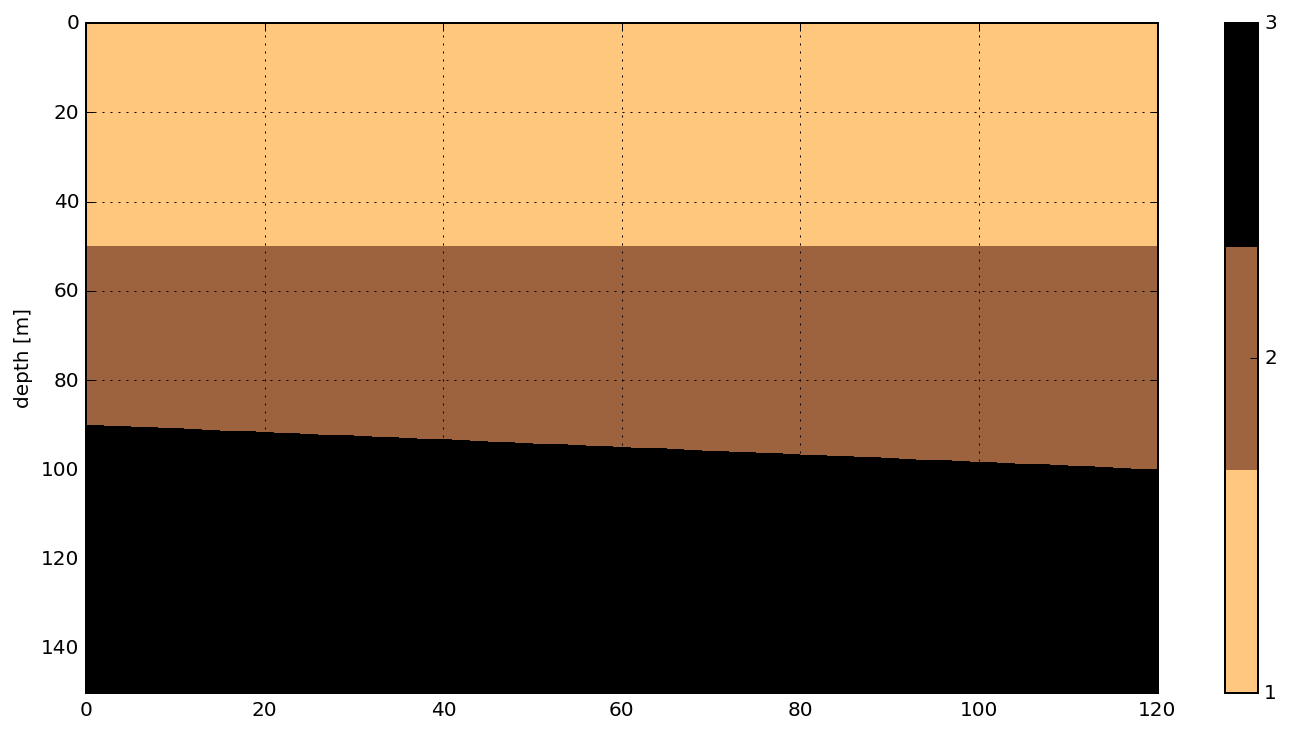

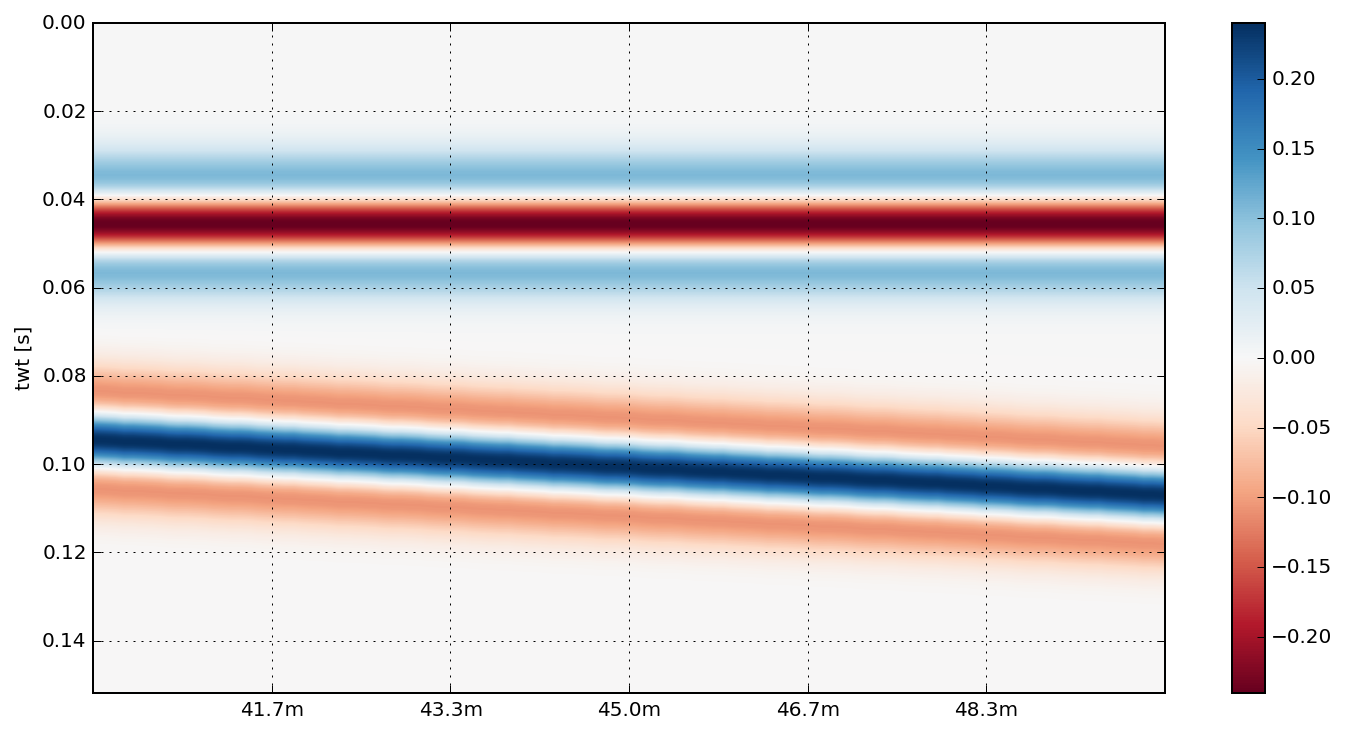

In [33]:
min_thickness = 40
max_thickness = 50

rock_grid1=make_wedge(n_traces,layer_1_thickness,min_thickness,max_thickness,srz)
seismic1=forward_model(rock_grid1,acprop,wavl,srz,srt)
plot_rock_grid(rock_grid1,srz), plt.ylabel('depth [m]')
plot_density(seismic1,srt), plt.ylabel('twt [s]')
update_xlabels(min_thickness,max_thickness,n_traces)

#### variable-offset stacks

The procedure is similar so I will go quickly through the main steps; first I need to define an array of elastic properties, this time Vs is required:

In [34]:
elprop=np.array([[2191,2.16,818],[1543,1.88,901],[2191,2.16,818]])

I will slightly change the shape of the wedge now and the thickness of the first layer:

In [35]:
ang = [5,20,40]
min_thickness=0
max_thickness=30
layer_1_thickness=30

wedge minimum thickness: 0.00 m
wedge maximum thickness: 30.00 m
wedge vertical sampling: 0.10 m
wedge samples, traces: 900x120


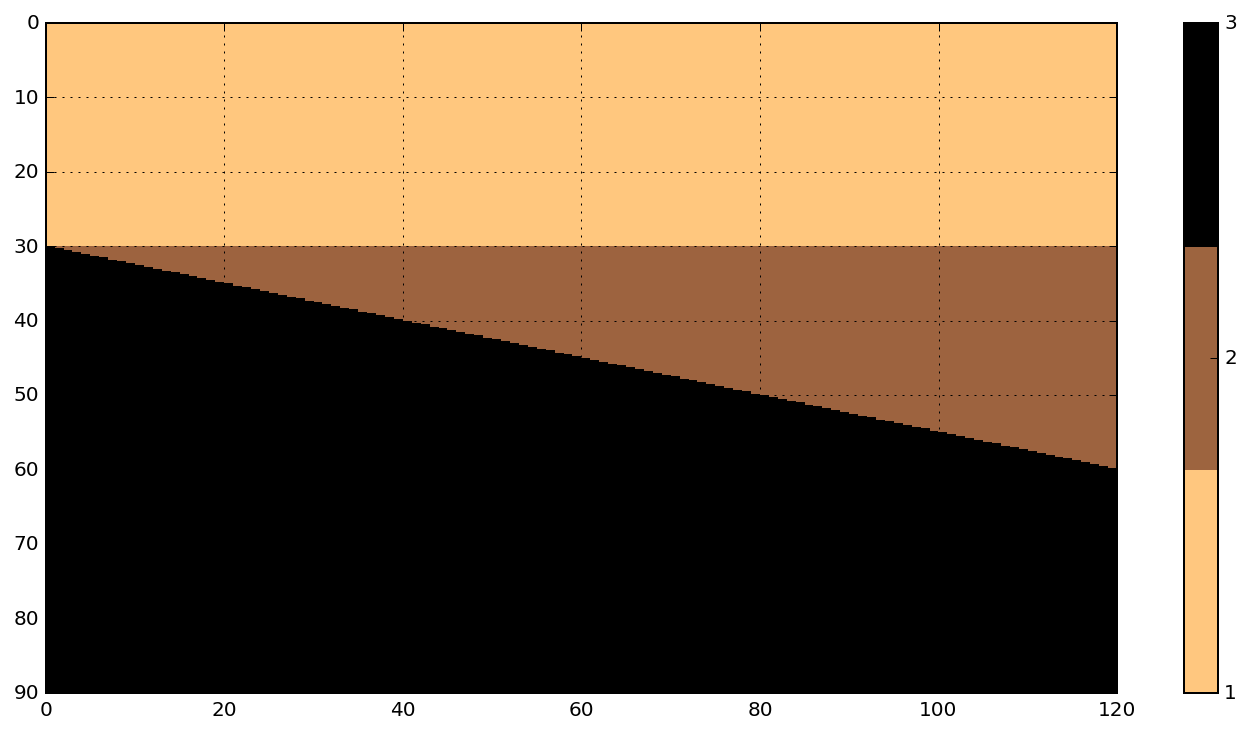

In [36]:
rock_grid2=make_wedge(n_traces,layer_1_thickness,min_thickness,max_thickness,srz)
plot_rock_grid(rock_grid2,srz)


model_vp,model_vs,model_rho = assign_el(rock_grid, elprop)
model_vp_time=agilegeo.avo.depth_to_time(model_vp,model_vp,srz,srt,twt=True)
model_vs_time=agilegeo.avo.depth_to_time(model_vs,model_vp,srz,srt,twt=True)
model_rho_time=agilegeo.avo.depth_to_time(model_rho,model_vp,srz,srt,twt=True)

rc_near, rc_mid, rc_far=make_rc_elastic(model_vp_time,model_vs_time,model_rho_time,ang)

near=make_synth(rc_near,wavl)
mid=make_synth(rc_mid,wavl)
far=make_synth(rc_far,wavl)

I can display the resulting seismic with `plot_density` again, or with another pretty specific function, `plot_partial_stacks`:

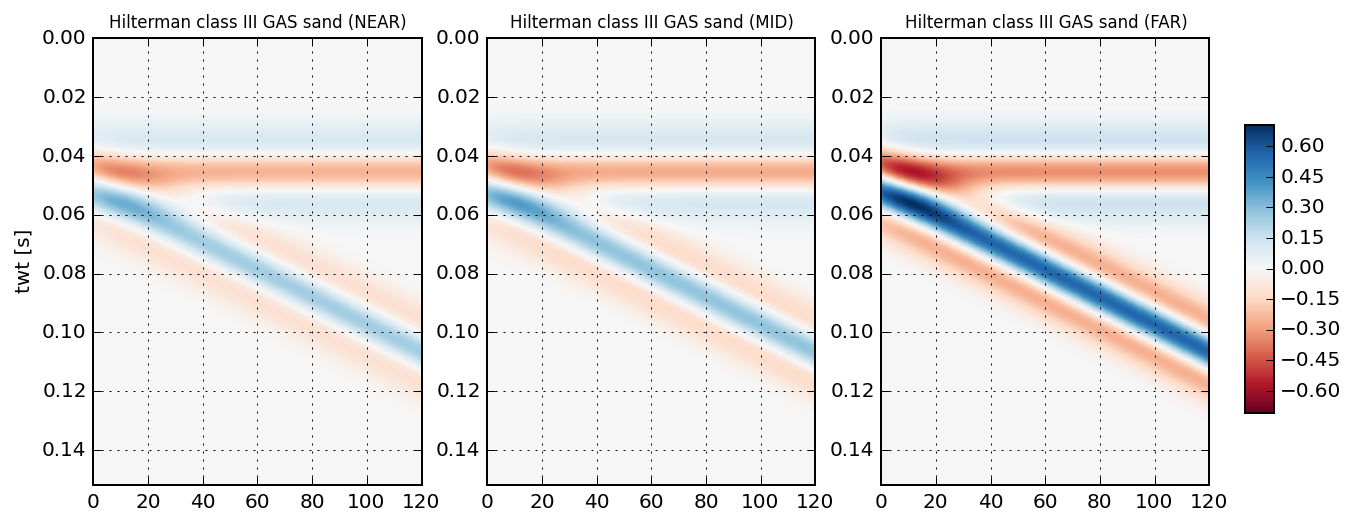

In [37]:
plot_partial_stacks(near,mid,far,srt,'Hilterman class III GAS sand')

Let's quickly build another 3 partial stacks using the helper function `forward_model_elastic`, this time for the brine sand scenario:

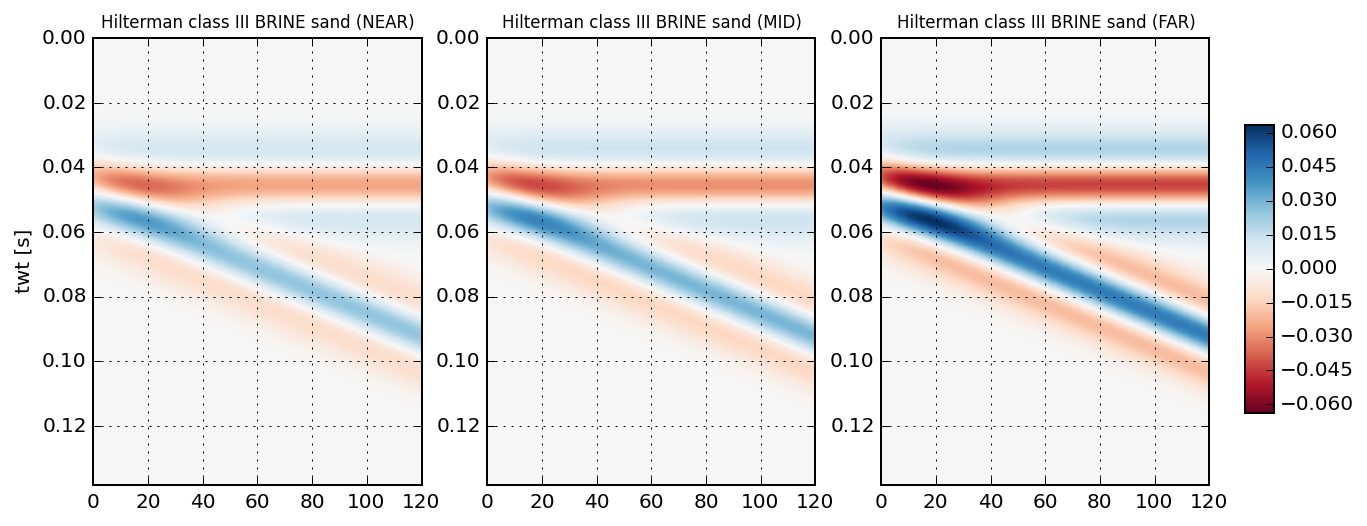

In [38]:
elprop_brine=np.array([[2191,2.16,818],[2134,2.11,860],[2191,2.16,818]])
near_brine,mid_brine,gas_brine=forward_model_elastic(rock_grid,elprop_brine,wavl,ang,srz,srt)
plot_partial_stacks(near_brine,mid_brine,gas_brine,srt,'Hilterman class III BRINE sand')

## automatic picking of top and bottom

This last function is only defined in `aawedge.py` so please refer to this file if you want to see how I've coded (I thought it was too long to put it here). Again, this small library I've built is available at <https://github.com/aadm/geophysical_notes>.

wedge minimum thickness: 1.00 m
wedge maximum thickness: 35.00 m
wedge vertical sampling: 0.10 m
wedge samples, traces: 750x200


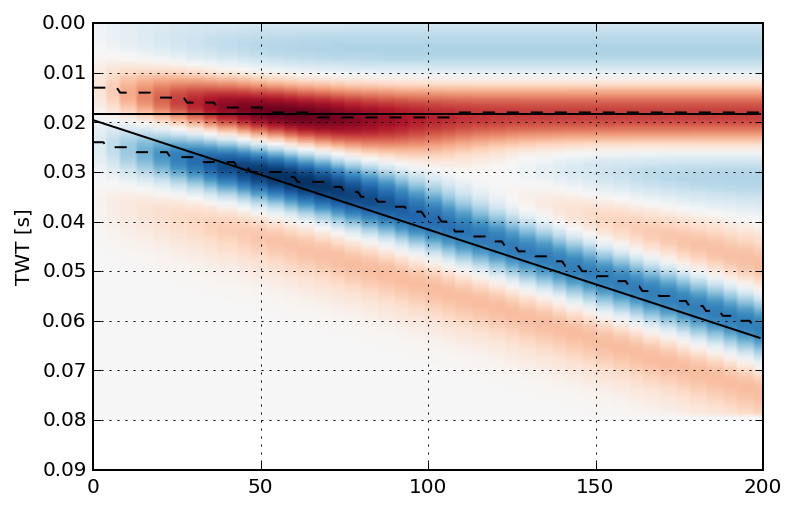

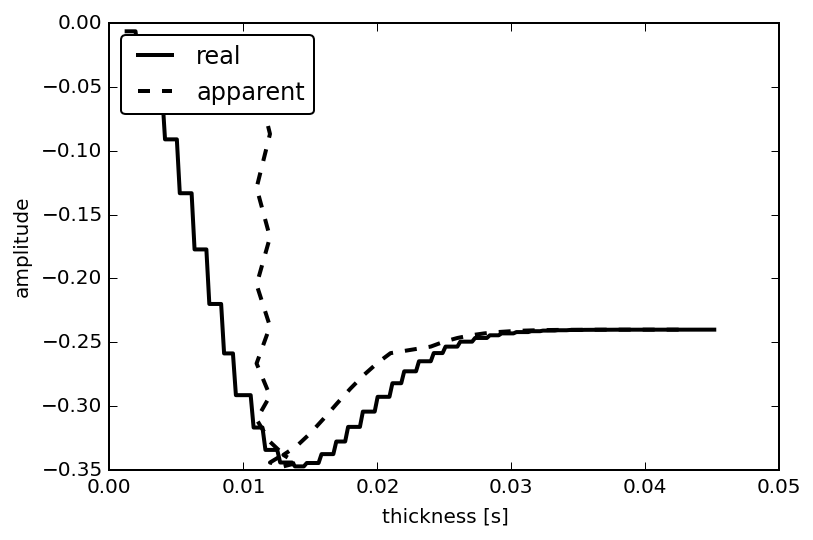

In [46]:
import aawedge

freq=30
srz=0.1   # 1 vertical sample in depth domain = 0.1 m
srt=0.001 # 1 vertical sample in time domain = 0.001 s = 1 ms
acprop=np.array([[2191,2.16,818],[1542,1.88,901],[2191,2.16,818]])

wavl=agilegeo.wavelet.ricker(0.128, srt, freq)
wedge=aawedge.make_wedge(200,20,min_thickness,max_thickness,srz)
sint=aawedge.forward_model(wedge,acprop,wavl,srz,srt)

topR,botR,topampR,botampR,topA,botA,topampA,botampA=\
aawedge.extract_amp(sint,acprop,20,min_thickness,max_thickness,srt,freq)

plt.figure()
plt.imshow(sint,extent=[0,sint.shape[1],sint.shape[0]*srt,0],cmap='RdBu',aspect='auto')
plt.plot(topR,'k')
plt.plot(topA,'--k')
plt.plot(botR,'k')
plt.plot(botA,'--k')
plt.grid()
plt.ylabel('TWT [s]')

thickness_real=botR-topR
thickness_app=botA-topA

plt.figure()
plt.plot(thickness_real,topampR,'k',lw=2,label='real')
plt.plot(thickness_app,topampA,'--k',lw=2,label='apparent')
plt.xlabel('thickness [s]')
plt.ylabel('amplitude')
plt.legend(loc='upper left',fancybox=True)

Finally, some of the common quick calculations to get tuning thickness etc.:

In [47]:
tr = 1 /(3*freq)        # theoretical temporal resolution
tt = 1/(2.6*freq)       # theoretical tuning thickness in time
zt = tt/2 * acprop[1,0] # theoretical tuning thickness in meters
Fd=freq*1.3

print "Ricker wavelet peak frequency (Fp): %.2f Hz" % freq
print "Ricker wavelet dominant frequency (Fd=Fp*1.3): %.2f Hz" % Fd
print 'Wavelet breadth (b=1/Fd): %.6f s' % (1/Fd)
# print 'Peak-to-trough time, a.k.a. "b/2" (b/2=1/2*Fd): %.6f s' % (1/(2*Fd))  % same thing as tuning thickness
print 'Search window for seismic events (n.samples=b/sample_rate): %d' % (int(1/(freq*1.3)/srt))
print "Average velocity (vel): %.0f m/s" % acprop[1,0]
print "Tuning thickness in time (tt=1/2.6*Fp): %.2f ms" % (tt*1e3)
print "Tuning thickness in depth (zt=tt/2*vel): %.2f m" % zt

Ricker wavelet peak frequency (Fp): 30.00 Hz
Ricker wavelet dominant frequency (Fd=Fp*1.3): 39.00 Hz
Wavelet breadth (b=1/Fd): 0.025641 s
Search window for seismic events (n.samples=b/sample_rate): 25
Average velocity (vel): 1542 m/s
Tuning thickness in time (tt=1/2.6*Fp): 12.82 ms
Tuning thickness in depth (zt=tt/2*vel): 9.88 m


## further readings

Agilegeo's (Matt Hall & Evan Bianco) notebooks and blog posts:

* <http://nbviewer.ipython.org/github/agile-geoscience/notebooks/blob/master/To_make_a_wedge.ipynb>
* <http://nbviewer.ipython.org/github/kwinkunks/notebooks/blob/master/Spectral_wedge.ipynb>
* <http://nbviewer.ipython.org/github/kwinkunks/notebooks/blob/master/Faster_wedges.ipynb>
* <http://nbviewer.ipython.org/github/kwinkunks/notebooks/blob/master/Variable_wedge.ipynb>

Also see Wes Hamlyn's tutorial on Leading Edge "Thin Beds, tuning and AVO" (December 2014):

* <https://github.com/seg/tutorials/tree/master/1412_Tuning_and_AVO>